# Stima infetti reali

Stima infetti reali con backcasting.

> Max Pierini

***

Si presenta una stima degli infetti reali in Italia con metodo backcasting [Phipps et al. 2020](https://doi.org/10.1098/rsos.200909) basato su

- decessi osservati
- Infection Fatality Rate (IFR)
- periodo di incubazione
- periodo onset-to-death (dai sintomi al decesso)

Il backend per la stima degli infetti reali è stato tradotto in `Python` dall'originale in linguaggio `IDL` (vedi [Robust estimates of the true (population) infection rate for COVID-19: a backcasting approach](https://zenodo.org/record/4277651)).

I dati di decessi e casi osservati sono tratti dal repository GitHub COVID-19 del [Dipartimento Protezione Civile](https://github.com/pcm-dpc/COVID-19/).

L'IFR stimato per l'Italia è tratto da Imperial College Report 34 [Brazeau, Verity et al. 2020](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-34-IFR/) (tabella pag 9).

> NB: per questioni temporali la stima è effettuata con 250 simulazioni Monte Carlo anziché 10'000 come nel lavoro di Phipps et al.

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.special as spsp

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

from IPython.display import display, Markdown, Latex

In [2]:
dt_start = dt.datetime.now()

In [3]:
df = pd.read_csv(
    "https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/"
    "dpc-covid19-ita-andamento-nazionale.csv",
    parse_dates=['data'], index_col='data'
)
df.index = df.index.normalize()

In [4]:
# Define independent parameters
day0 = 0  # 02 February 2020
n_days = df.index.size - 1
n_monte = 250  # 10000
cov1 = 0.86
cov2 = 0.45
dt_incubation_min = 4.1
dt_incubation_max = 7.0
dt_onset_min = 12.8
dt_onset_max = 19.2
ifr_min = 2.03 / 100  # 0.78 / 100  # 0.0037
ifr_max = 2.45 / 100  # 1.79 / 100  # 0.0115
missing_value = -1.0e34

In [5]:
# Declare variables
det_rate_02p5 = np.ndarray(n_days)
det_rate_05p0 = np.ndarray(n_days)
det_rate_95p0 = np.ndarray(n_days)
det_rate_97p5 = np.ndarray(n_days)
det_rate_median = np.ndarray(n_days)
det_rate_monte = np.ndarray((n_days, n_monte))
dn_inf = np.ndarray(n_days)
n_cas = np.ndarray(n_days)
n_dfat = np.ndarray(n_days)
n_fat = np.ndarray(n_days)
n_inf_02p5 = np.ndarray(n_days)
n_inf_05p0 = np.ndarray(n_days)
n_inf_95p0 = np.ndarray(n_days)
n_inf_97p5 = np.ndarray(n_days)
n_inf_median = np.ndarray(n_days)
n_inf_monte = np.ndarray((n_days, n_monte))

In [6]:
# Initialise variables
det_rate_02p5[:] = missing_value
det_rate_05p0[:] = missing_value
det_rate_95p0[:] = missing_value
det_rate_97p5[:] = missing_value
det_rate_median[:] = missing_value
det_rate_monte[:,:] = missing_value
dn_inf[:] = missing_value
n_cas[:] = missing_value
n_dfat[:] = missing_value
n_fat[:] = missing_value
n_inf_02p5[:] = missing_value
n_inf_05p0[:] = missing_value
n_inf_95p0[:] = missing_value
n_inf_97p5[:] = missing_value
n_inf_median[:] = missing_value
n_inf_monte[:,:] = missing_value

In [7]:
# Read data
n_cas = df.totale_casi.values.ravel()[1:]
n_fat = df.deceduti.values.ravel()[1:]
n_dfat = df.deceduti.diff().values.ravel()[1:]
# fix errors
n_dfat[n_dfat<0] = 0

In [8]:
# Derive the implied means and standard deviations of the parameter
# distributions, assuming that the specified uncertainty ranges for each
# paramter represent the 95% confidence intervals of a normal distribution
ifr_mean = 0.5 * (ifr_min + ifr_max)
dt_incubation_mean = 0.5 * (dt_incubation_min + dt_incubation_max)
dt_onset_mean = 0.5 * (dt_onset_min + dt_onset_max)

In [9]:
ifr_sd = (ifr_max - ifr_min) / (sps.norm.isf(.025) - sps.norm.isf(.975))
dt_incubation_sd = (dt_incubation_max - dt_incubation_min) / (sps.norm.isf(.025) - sps.norm.isf(.975))
dt_onset_sd = (dt_onset_max - dt_onset_min) / (sps.norm.isf(.025) - sps.norm.isf(.975))

Distribuzioni dei parametri:

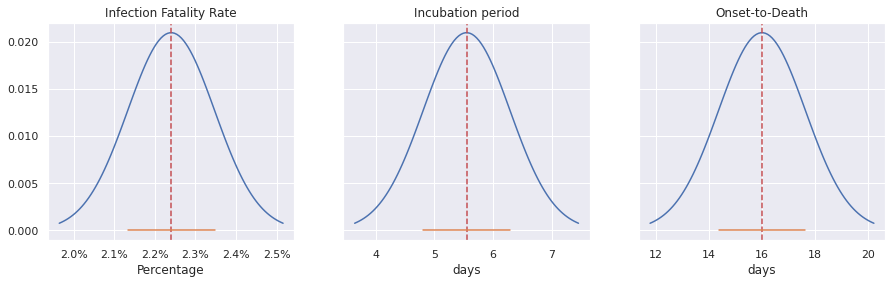

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

ifr_dist = sps.norm(loc=ifr_mean, scale=ifr_sd)
ifr_X = np.linspace(ifr_dist.ppf(.005), ifr_dist.ppf(1-.005), 100)
ifr_Y = ifr_dist.pdf(ifr_X)
ifr_Y /= ifr_Y.sum()
ax[0].plot(ifr_X, ifr_Y)
ax[0].axvline(ifr_mean, ls='--', color='r')
ax[0].plot([ifr_mean-ifr_sd, ifr_mean+ifr_sd], [0,0])
ax[0].set_title('Infection Fatality Rate')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
ax[0].set(
    xlabel='Percentage'
)

dt_incubation_dist = sps.norm(loc=dt_incubation_mean, scale=dt_incubation_sd)
dt_incubation_X = np.linspace(dt_incubation_dist.ppf(.005), dt_incubation_dist.ppf(1-.005), 100)
dt_incubation_Y = dt_incubation_dist.pdf(dt_incubation_X)
dt_incubation_Y /= dt_incubation_Y.sum()
ax[1].plot(dt_incubation_X, dt_incubation_Y)
ax[1].axvline(dt_incubation_mean, ls='--', color='r')
ax[1].plot([dt_incubation_mean-dt_incubation_sd, dt_incubation_mean+dt_incubation_sd], [0,0])
ax[1].set_title('Incubation period')
ax[1].set(
    xlabel='days'
)

dt_onset_dist = sps.norm(loc=dt_onset_mean, scale=dt_onset_sd)
dt_onset_X = np.linspace(dt_onset_dist.ppf(.005), dt_onset_dist.ppf(1-.005), 100)
dt_onset_Y = dt_onset_dist.pdf(dt_onset_X)
dt_onset_Y /= dt_onset_Y.sum()
ax[2].plot(dt_onset_X, dt_onset_Y)
ax[2].axvline(dt_onset_mean, ls='--', color='r')
ax[2].plot([dt_onset_mean-dt_onset_sd, dt_onset_mean+dt_onset_sd], [0,0])
ax[2].set_title('Onset-to-Death')
ax[2].set(
    xlabel='days'
)

plt.show()

In [11]:
# Derive the estimated cumulative number of infections, using a Monte Carlo
# method to sample parameter uncertainty
for monte in tqdm(range(n_monte)):
    
  # Derive a random value for ifr
    x1 = sps.norm.rvs(loc=0, scale=1, size=1)
    while (abs(x1) > sps.norm.isf(.025)):
        x1 = sps.norm.rvs(loc=0, scale=1, size=1)
    ifr = ifr_mean + x1 * ifr_sd
    
    # Derive a random value for dt_incubation
    x2 = sps.norm.rvs(loc=0, scale=1, size=1)
    while (abs(x2) > sps.norm.isf(.025)):
        x2 = sps.norm.rvs(loc=0, scale=1, size=1)
    dt_incubation = dt_incubation_mean + x2 * dt_incubation_sd
    
    # Derive a random value for dt_onset
    x3 = sps.norm.rvs(loc=0, scale=1, size=1)
    while (abs(x3) > sps.norm.isf(.025)):
        x3 = sps.norm.rvs(loc=0, scale=1, size=1)
    dt_onset = dt_onset_mean + x3 * dt_onset_sd
    
    # Derive the parameters for the Gamma distribution
    dt_death = dt_incubation + dt_onset
    sd1 = cov1 * dt_incubation
    sd2 = cov2 * dt_onset
    sd = np.sqrt(sd1**2 + sd2**2)
    cov = sd / dt_death
    alpha = 1.0 / cov**2
    beta = dt_death * cov**2
    denominator = beta**alpha * spsp.gamma(alpha)
    
    # Derive the estimated cumulative number of infections
    #
    # Reset the array containing daily new infections
    dn_inf[:] = 0.0

    # Loop over each day to apportion fatalities
    for i_fat in range(n_days)[::-1]:

        # Loop over each preceding day to receive fatalities
        for i_inf in range(i_fat)[::-1]:

            # Calculate the value of the Gamma function
            x = float(i_fat - i_inf)
            pdf = (x**(alpha-1.0) * np.exp(0.0-x/beta)) / denominator

            # Estimate the number of new infections
            dn_inf[i_inf] = dn_inf[i_inf] + (pdf * n_dfat[i_fat]) / ifr
            
    # Scale the number of new infections to allow for the fraction of fatalities
    # that have not occurred yet
    for i in range(n_days-1):
        x = float(n_days - 1 - i)
        cdf = spsp.gammainc(alpha, x/beta)
        dn_inf[i] = dn_inf[i] / cdf

    # Calculate the cumulative number of new infections
    n_inf_monte[0, monte] = dn_inf[0]
    for i in range(n_days)[1:]:
        n_inf_monte[i, monte] = n_inf_monte[i-1, monte] + dn_inf[i]

    # Derive the implied detection rates
    for i in range(n_days):
        if (n_inf_monte[i, monte] > 0.5):
            det_rate_monte[i, monte] = n_cas[i] / n_inf_monte[i, monte]

#; Remove any incomplete Monte Carlo samples for the implied detection rates
for i in range(n_days):
    if (min(det_rate_monte[i, :]) < -1.0e30):
        det_rate_monte[i, :] = missing_value

# Risultati

In [12]:
n_inf_median = np.median(n_inf_monte, axis=1)

In [13]:
# 95% CI
n_inf_lo, n_inf_hi = np.percentile(n_inf_monte, [2.5, 97.5], axis=1)
# 50% CI
n_inf_25, n_inf_75 = np.percentile(n_inf_monte, [25, 75], axis=1)

In [14]:
_ = """fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index[1:], n_inf_median)
ax.fill_between(
    df.index[1:],
    n_inf_lo, n_inf_hi,
    alpha=.25
)
ax.plot(df.index[1:], n_cas)
ax.semilogy()
ax.axhline(6e7, color='k', ls='--')
ax.set(
    ylim=(1, ax.get_ylim()[1])
)
plt.show()"""

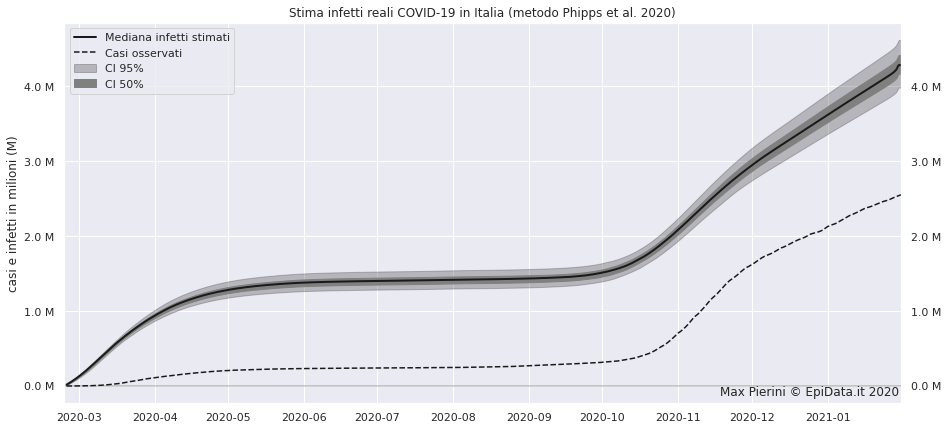

In [15]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df.index[1:], n_inf_median, color='k', lw=2, label='Mediana infetti stimati')
ax.fill_between(
    df.index[1:],
    n_inf_lo, n_inf_hi,
    alpha=.25, color='k',
    label='CI 95%'
)
ax.fill_between(
    df.index[1:],
    n_inf_25, n_inf_75,
    color='grey',
    label='CI 50%'
)
ax.plot(df.index[1:], n_cas, label='Casi osservati', ls='--', color='k')
#ax.axhline(6e7, color='k', ls='--')
ax.ticklabel_format(axis='y', style='plain')
#ax.set(ylim=(0, ax.get_ylim()[1]))
#ax.set(
#    yticks=np.arange(0, max(ax.get_yticks()), 2.5e6)
#)
ylim = ax.get_ylim()
ax.set(
    yticks=ax.get_yticks(),
    yticklabels=[f"{i:.1f} M" for i in ax.get_yticks()/1e6],
)
ax.set(
    xlim=(df.index[0], df.index[-1]),
    ylim=ylim,
    title='Stima infetti reali COVID-19 in Italia (metodo Phipps et al. 2020)',
    ylabel='casi e infetti in milioni (M)'
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
ax.axhline(0, color='k', alpha=.25)
ax.legend(loc='upper left')
ax.text(
    df.index[-2], 0,
    'Max Pierini © EpiData.it 2020',
    ha='right', va='top'
)
plt.show()

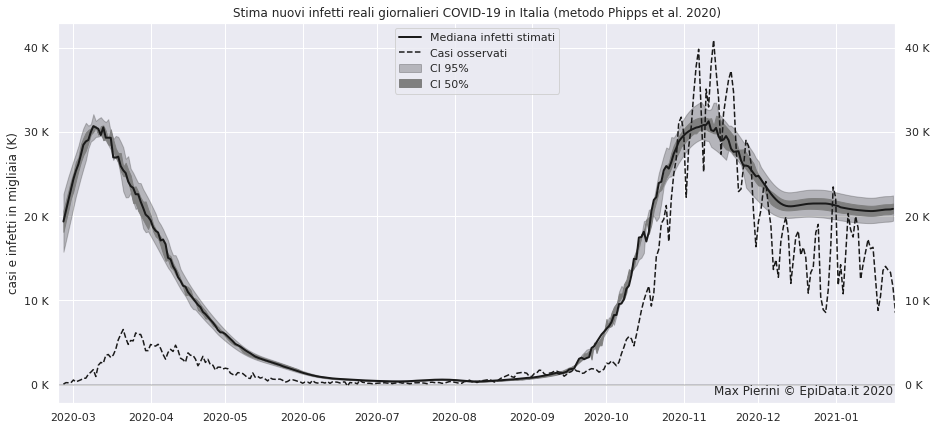

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df.index[2:-7], np.diff(n_inf_median)[:-7], color='k', lw=2, label='Mediana infetti stimati')
ax.fill_between(
    df.index[2:-7],
    np.diff(n_inf_lo)[:-7], np.diff(n_inf_hi)[:-7],
    alpha=.25, color='k',
    label='CI 95%'
)
ax.fill_between(
    df.index[2:-7],
    np.diff(n_inf_25)[:-7], np.diff(n_inf_75)[:-7],
    color='grey',
    label='CI 50%'
)
ax.plot(df.index[2:], np.diff(n_cas), label='Casi osservati', ls='--', color='k')
#ax.axhline(6e7, color='k', ls='--')
ax.ticklabel_format(axis='y', style='plain')
ylim=ax.get_ylim()
ax.set(
    yticks=ax.get_yticks(),
    yticklabels=[f"{i:.0f} K" for i in ax.get_yticks()/1e3],
)
ax.set(
    xlim=(df.index[0], df.index[-7]),
    ylim=ylim,
    title='Stima nuovi infetti reali giornalieri COVID-19 in Italia (metodo Phipps et al. 2020)',
    ylabel='casi e infetti in migliaia (K)'
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
ax.axhline(0, color='k', alpha=.25)
ax.legend(loc='upper center')
ax.text(
    df.index[-8], 0,
    'Max Pierini © EpiData.it 2020',
    ha='right', va='top'
)
plt.show()

In [17]:
det_rate_median = np.median(det_rate_monte, axis=1)

In [18]:
# 95% CI
det_rate_lo, det_rate_hi = np.percentile(det_rate_monte, [2.5, 97.5], axis=1)
# 50% CI
det_rate_25, det_rate_75 = np.percentile(det_rate_monte, [25, 75], axis=1)

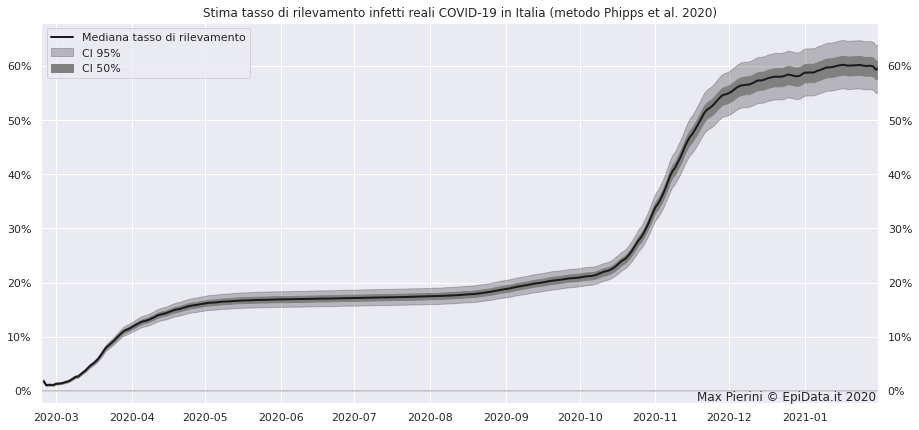

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df.index[1:], det_rate_median, color='k', lw=2, label='Mediana tasso di rilevamento')
ax.fill_between(
    df.index[1:],
    det_rate_lo, det_rate_hi,
    alpha=.25, color='k',
    label='CI 95%'
)
ax.fill_between(
    df.index[1:],
    det_rate_25, det_rate_75,
    color='grey',
    label='CI 50%'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
ax.set(
    xlim=(df.index[0], df.index[-1]),
    title='Stima tasso di rilevamento infetti reali COVID-19 in Italia (metodo Phipps et al. 2020)'
)
ax.legend(loc='upper left')
ax.text(
    df.index[-2], 0,
    'Max Pierini © EpiData.it 2020',
    ha='right', va='top'
)
ax.axhline(0, color='k', alpha=.25)
plt.show()

In [20]:
dt_end = dt.datetime.now()
dt_time = dt_end - dt_start
print("Computed in", dt_time)

Computed in 0:07:24.786275
